# **Ejercicio series de tiempo**

## **Librerías y módulos necesarios**

In [421]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime
from scipy.stats import shapiro
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
from statsmodels.tsa import seasonal
from sklearn.metrics import r2_score
from yahoo_fin.stock_info import get_data
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# **Descriptivo del conjunto de datos**

## **Datos**: **Banco Davivienda S.A.**

En este ejercicio se estará trabajando con un conjunto de datos del banco **Davivienda**.

In [422]:
ticker = 'PFDAVVNDA.CL' # Código alfanumérico (etiqueta de la base de datos)
resolution = '1d' # Muestra los datos diarios 
end_date = datetime.now()
start_date = '01-01-2023'


In [423]:
data = get_data(ticker, start_date = start_date, end_date = end_date, interval = resolution, index_as_date = False)
data.drop('ticker', axis = 1, inplace = True)

## **Características de los datos**

In [424]:
data.head()

,date,open,high,low,close,adjclose,volume
0,2023-01-02,27560.0,27560.0,27080.0,27080.0,25756.806641,34003.0
1,2023-01-03,27040.0,27150.0,27040.0,27150.0,25823.386719,5334.0
2,2023-01-04,27150.0,27210.0,27150.0,27210.0,25880.455078,6130.0
3,2023-01-05,27300.0,27780.0,27300.0,27750.0,26394.070312,5680.0
4,2023-01-06,27800.0,28700.0,27800.0,28700.0,27297.650391,49937.0


In [425]:
data.tail()

,date,open,high,low,close,adjclose,volume
440,2024-09-09,17800.0,17500.0,17440.0,17440.0,17440.0,10034.0
441,2024-09-10,17440.0,17480.0,17440.0,17480.0,17480.0,3067.0
442,2024-09-11,17480.0,17700.0,17620.0,17620.0,17620.0,17471.0
443,2024-09-12,17620.0,18200.0,17640.0,18200.0,18200.0,63369.0
444,2024-09-13,18200.0,18400.0,18200.0,18340.0,18340.0,27826.0


In [426]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      445 non-null    datetime64[ns]
 1   open      437 non-null    float64       
 2   high      437 non-null    float64       
 3   low       437 non-null    float64       
 4   close     437 non-null    float64       
 5   adjclose  437 non-null    float64       
 6   volume    437 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 24.5 KB


In [427]:
data.shape

(445, 7)

In [428]:
data.describe()

,date,open,high,low,close,adjclose,volume
count,445,437.000000,437.000000,437.000000,437.000000,437.000000,4.370000e+02
mean,2023-11-08 00:00:00.000000256,20079.167482,20232.554209,19876.650319,20069.838762,19741.643485,9.217293e+05
min,2023-01-02 00:00:00,15420.000000,15600.000000,15340.000000,15340.000000,15340.000000,0.000000e+00
25%,2023-06-06 00:00:00,18200.000000,18260.000000,17940.000000,18180.000000,17857.664062,8.930000e+03
50%,2023-11-08 00:00:00,19900.000000,20000.000000,19800.000000,19900.000000,19700.000000,2.392900e+04
75%,2024-04-11 00:00:00,21440.000000,21600.000000,21000.000000,21460.000000,21000.000000,5.583300e+04
max,2024-09-13 00:00:00,28700.000000,29000.000000,28700.000000,29000.000000,27582.990234,3.673912e+08
std,NaN,2885.007718,2920.552806,2830.601125,2906.466259,2590.568576,1.757356e+07


Nótese que luego de analizar las principales características de los datos podemos deducir que cuenta con 445 observaciones y 7 columnas, de las cuales todas son de tipo numérico y la fecha está asignada como un datetime. La fecha de inicio de los datos es **01-01-2023** y la fecha final de los datos es **13-09-2024**.

## **Comportamiento de la serie**

En este caso se visualizarán los datos por medio de una serie de tiempo. Por lo tanto es importante conocer el comportamiento inicial de la serie. 

Los lags son los retrasos o desfases en una serie temporal, que representan el valor de la variable en momentos previos utilizados para analizar la relación con el valor actual.

In [429]:
if data['adjclose'].isnull().sum() > 0:
    data['adjclose'] = data['adjclose'].fillna(method = 'ffill') 
    # Llena los nulos con el valor anterior más cercano en la columna (método de "forward fill"), propagando los últimos valores no nulos hacia adelante.

plt.rcParams['figure.figsize'] = (8, 4)

En el siguiente gráfico, se observa la serie de tiempo correspondiente al precio de cierre ajustado de la acción de Davivienda a lo largo del tiempo anteriormente ya mencionado.

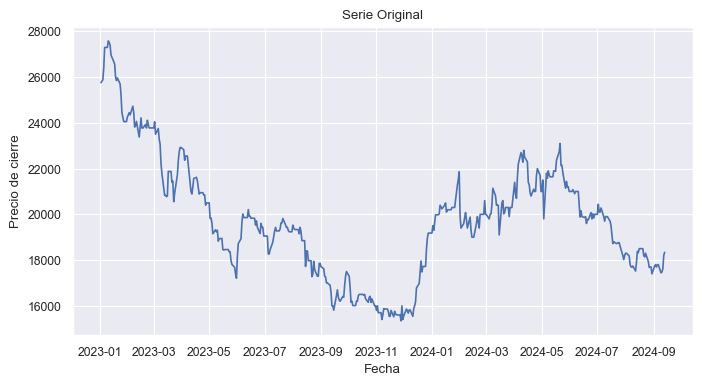

In [430]:
# Serie original
sns.set_theme()
sns.set_context("paper")
sns.lineplot(data = data, x = data.date, y = data.adjclose);
plt.title('Serie Original')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.show()

En la gráfica se observa una caída brusca en el precio al inicio del periodo, seguida de variaciones con una tendencia a la baja hasta finales de 2023. A partir de 2024, los precios muestran mayor volatilidad con algunos picos, aunque se mantiene la tendencia descendente. La serie temporal indica que los precios de la acción han experimentado cambios significativos, con una pérdida de valor general a lo largo del tiempo. Dada la variabilidad observada, parece que esta serie **NO** es estacionaria, ya que no muestra estabilidad a lo largo del periodo.

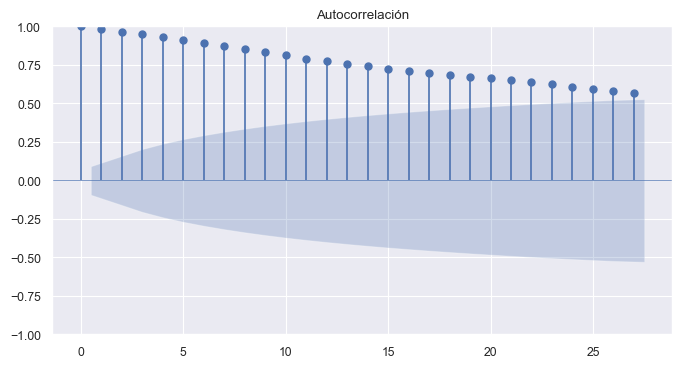

In [431]:
# Autocorrelación
# Lag: observación de una variable en un momento anterior al momento actual.
plot_acf(data['adjclose'], linewidth = 0.5)  
plt.title('Autocorrelación')
plt.show()

La gráfica de autocorrelación muestra que los primeros lags tienen una autocorrelación alta, lo que indica que los valores de la serie están fuertemente correlacionados en intervalos de tiempo cercanos. A medida que aumenta el número de lags, la autocorrelación disminuye de manera gradual, lo que sugiere que los valores más alejados en el tiempo tienen una relación más débil. Nótese que la mayoría de barras caen sobre la zona sombreada lo que indica que la correlación en estos valores NO es significativa.

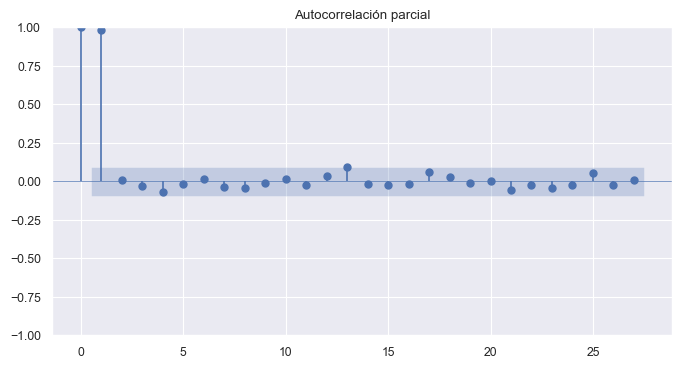

In [432]:
# Autocorrelación Parcial
plot_pacf(data['adjclose'], linewidth = 0.5)  
plt.title('Autocorrelación parcial')
plt.show()

La gráfica de autocorrelación parcial muestra que la relación entre el último día y el día anterior es bastante alta, casi perfecta, lo que sugiere una fuerte dependencia entre estos valores consecutivos. Sin embargo, a medida que se incrementan los lags, la autocorrelación parcial disminuye rápidamente, y los días posteriores muestran correlaciones muy bajas y poco significativas.

### **Test de Dickey-Fuller.**

En esta parte se usará la prueba de `Dickey-Fuller` para verificar si la serie de tiempo es estacionaria o no. 

- **Hipótesis Nula (H₀):** La serie de tiempo es NO estacionaria (tiene una raíz unitaria)
- **Hipótesis Alternativa (H₁):** La serie de tiempo es estacionaria (no tiene una raíz unitaria)

In [433]:
adf_result = adfuller(data["adjclose"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -2.387806
p-value: 0.145208


Dado que el p-valor (`0.14`) es mayor que el nivel de significancia (`0.05`) entonces NO rechazamos la hipótesis nula y por tanto se afirma está misma. Es decir, la serie de tiempo NO es estacionaria. 

### **Descomposición de la serie**

La descomposición de una serie temporal permite separar sus componentes principales: tendencia, estacionalidad y ruido. Esto facilita la identificación de patrones ocultos, mejora los modelos predictivos y ayuda a analizar mejor los efectos de largo plazo y las fluctuaciones estacionales, aislando el ruido aleatorio.

En esta parte, intentaremos descomponer la serie temporal y, en consecuencia, estacionarla utilizando la función `_seasonal.seasonal decompose` . Probemos primero con el modelo aditivo de la descomposición. 

El **método aditivo** de descomposición es importante porque asume que los componentes de la serie temporal (tendencia, estacionalidad y ruido) se combinan de forma aditiva, es decir, la serie observada es la suma de estos tres elementos: $( Y(t) = T(t) + S(t) + R(t) )$. Este método es especialmente útil cuando las variaciones estacionales y el ruido permanecen constantes a lo largo del tiempo, independientemente del nivel de la tendencia.

In [434]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
# El comportamiento de la serie tiene un ciclo estacional que se repite cada 20 días.

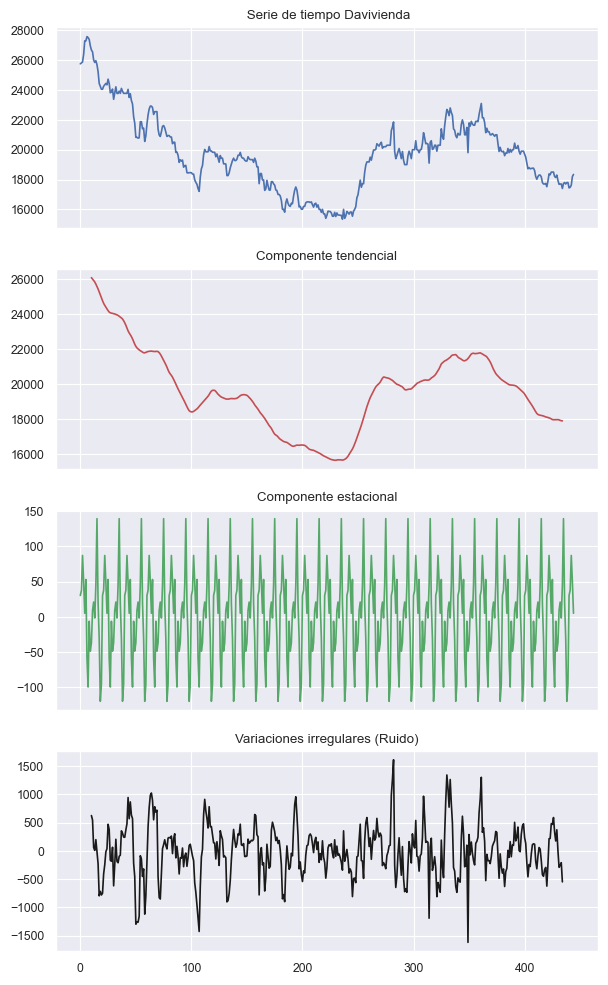

In [435]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(7, 12)
sns.set_theme()
sns.set_context("paper")

data['adjclose'].plot(ax = axarr[0], color = 'b', linestyle = '-')
axarr[0].set_title(' Serie de tiempo Davivienda')

pd.Series(data = decompose_model.trend, index = data.index).plot(color = 'r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial')

pd.Series(data = decompose_model.seasonal, index = data.index).plot(color = 'g', linestyle = '-', ax=axarr[2])
axarr[2].set_title('Componente estacional')

pd.Series(data = decompose_model.resid, index = data.index).plot(color = 'k', linestyle = '-', ax=axarr[3])
axarr[3].set_title('Variaciones irregulares (Ruido)');


En el primer gráfico, el **componente tendencial** muestra una disminución general a lo largo del tiempo, con algunas variaciones menores. El segundo gráfico representa la **estacionalidad**, que exhibe un patrón repetitivo con una amplitud constante, lo que indica un comportamiento cíclico regular. Finalmente, el último gráfico muestra el **ruido**, compuesto por variaciones aleatorias sin un patrón definido, lo que sugiere que estos movimientos no pueden ser explicados ni por la tendencia ni por la estacionalidad.

Ahora ejecutamos la prueba ADF sobre los residuos del modelo aditivo.

In [436]:
adf_result = adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]], autolag = 'AIC')
print('p-valor:', adf_result[1])

p-valor: 5.07656783913623e-13


Aplicando la prueba a los residuos del modelo aditivo obtenemos un p-valor de **5.07656783913623e-13**, que es mucho menor que el obtenido con la serie temporal original.

### **Prueba de normalidad.**
Ahora, veamos la normalidad del conjunto de datos residuales. 



- **Hipótesis Nula (H₀):** La muestra parece provenir de una distribución normal. 
- **Hipótesis Alternativa (H₁):** La muestra NO parece provenir de una distribución normal. 

In [437]:
decompose_model = seasonal.seasonal_decompose(data["adjclose"].tolist(),period = 20, model = 'additive')
resid_clean = decompose_model.resid
resid_clean = np.where(np.isinf(resid_clean), np.nan, resid_clean)  # Reemplazar infinitos por NaN
resid_clean = resid_clean[~np.isnan(resid_clean)]  # Eliminar los NaN

# Reemplaza los valores infinitos por NA y luego elimina los NA
stat , p = shapiro(resid_clean)
print('Statistics = %.3f, p = %.3f' % (stat, p))

Statistics = 0.986, p = 0.000


Dado que el p-valor es un valor muy chiquito, menor que el valor de significancia (`0.05`) se rechaza la hipótesis nula y se afirma la alternativa, es decir la muestra de los residuos NO parece provenir de una distribución normal.

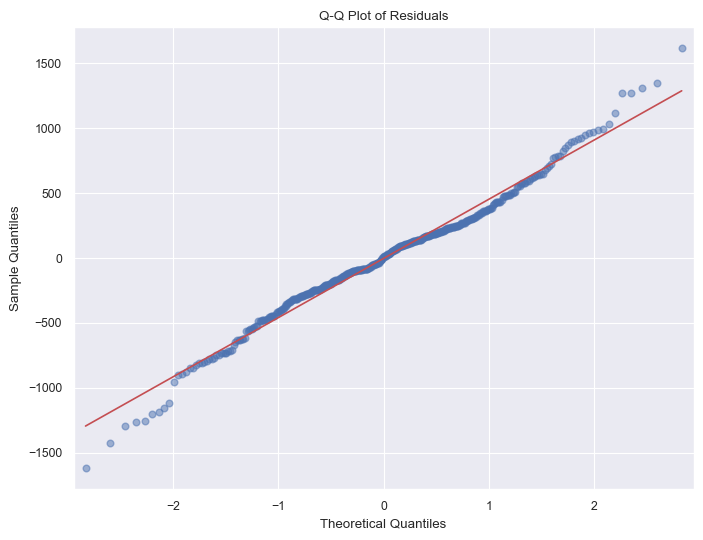

In [438]:
decompose_model = seasonal.seasonal_decompose(data['adjclose'], period=20, model='additive')
plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

La gráfica muestra un indicio de normalidad significativa en el conjunto de datos residuales de Davivienda. Sin embargo, notamos que algunos residuos presentan una tendencia NO normal respecto al resto de datos de la muestra, lo cual confirma lo anteriormente dicho en la prueba de normalidad.

# **Modelo ARIMA**

El objetivo del análisis de series temporales es construir un modelo matemático capaz de capturar y explicar los patrones observados en una serie temporal, permitiendo no solo comprender su comportamiento histórico, sino también predecir con precisión su evolución futura.

## **Diferenciación**

Dado que ya observamos que la serie de tiempo correspondiente a los datos del Banco Davivienda no son estacionarios, entonces, usaremos la diferenciación para estacionarlos y posteriormente usar el Modelo `ARIMA` (Autorregresivo integrado de media móvil).

La diferenciación busca convertir una serie temporal no estacionaria en estacionaria, eliminando tendencias y preparando los datos para análisis y predicciones más precisas mediante modelos adecuados.

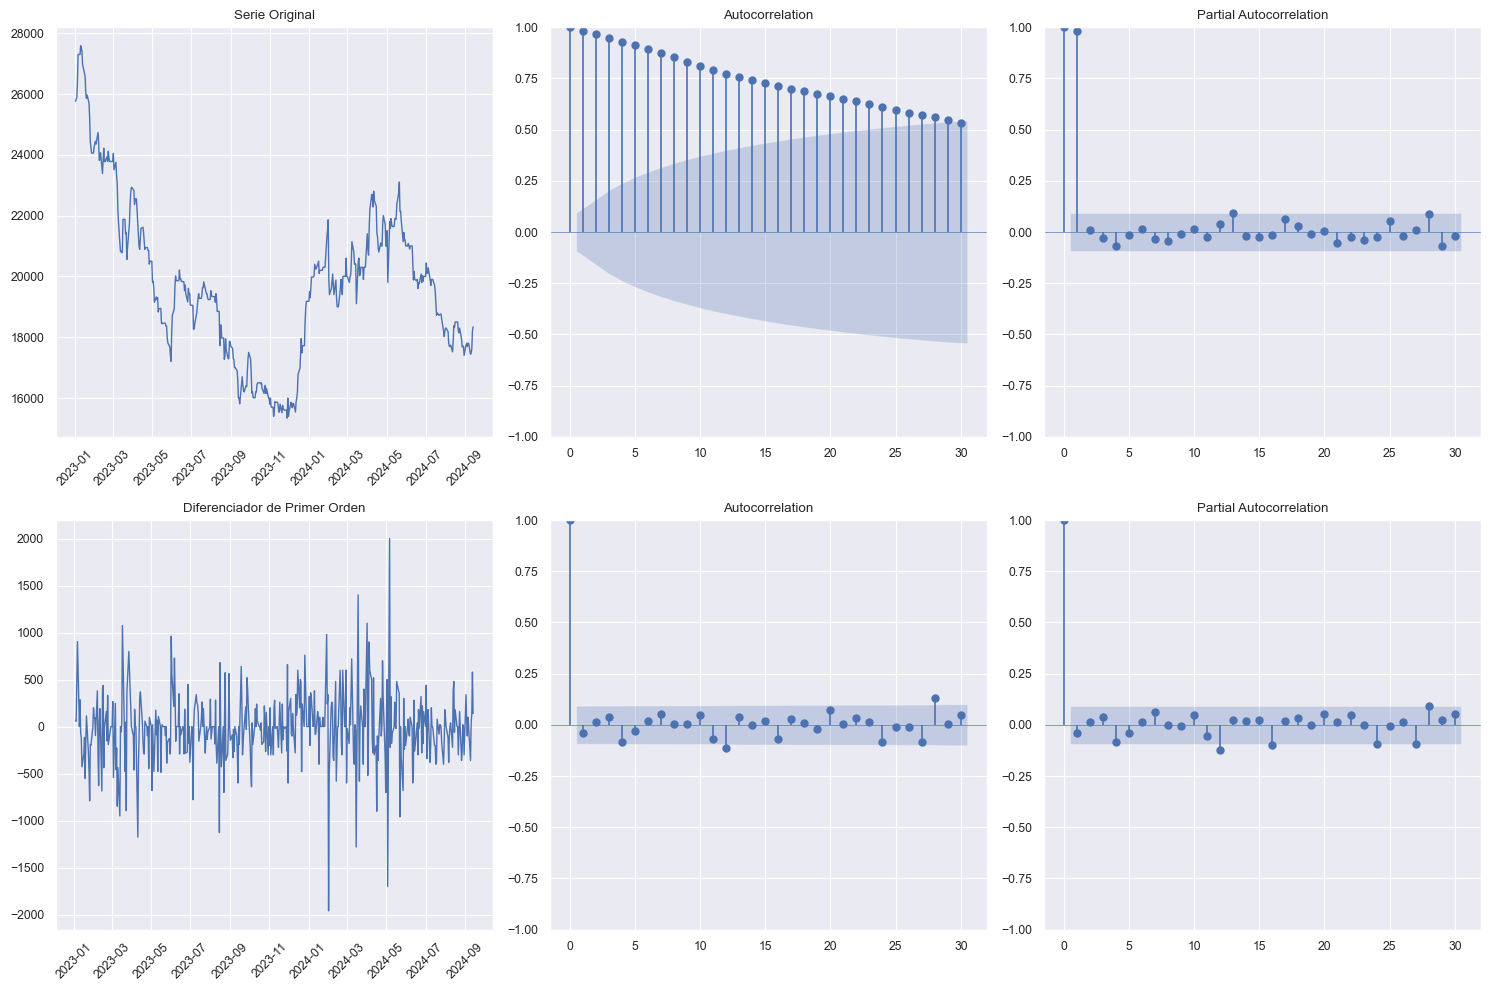

In [439]:
plt.rcParams.update({'text.usetex'     : False})
plt.rcParams.update({'figure.figsize'  : (15, 10)})

nlag = 30
fig, axes = plt.subplots(2, 3, sharex = False)

# Serie Original
axes[0, 0].plot(data['date'], data['adjclose'], linewidth = 1)  
axes[0, 0].set_title('Serie Original')
plot_acf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 1])
plot_pacf(data["adjclose"], lags = nlag, linewidth = 0.5, ax = axes[0, 2])

# Diferenciador de Primer Orden
axes[1, 0].plot(data["date"], data['adjclose'].diff(), linewidth = 1)
axes[1, 0].set_title('Diferenciador de Primer Orden')
plot_acf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[1, 1])
plot_pacf(data["adjclose"].diff().dropna(), lags = nlag, linewidth = 0.5, ax = axes[1, 2])

# Rotar los valores del eje x solo para las gráficas de las series temporales
for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

plt.tight_layout()
plt.show()


Después de aplicar el diferenciador de primer orden, la serie se vuelve más estacionaria, eliminando la tendencia a largo plazo. Esto se confirma en los gráficos ACF y PACF de la serie diferenciada, donde las correlaciones son más débiles, lo que indica que el proceso de diferenciación ha sido efectivo para eliminar la tendencia original y facilitar un análisis más claro de los cambios en los valores recientes.

Comprobemos la estacionaridad de la primera diferenciación con la prueba de `Dickey-Fuller`

In [440]:
adjclose_diff = data["adjclose"].diff().dropna()
adf_result2 = adfuller(adjclose_diff)
print('ADF Statistic: %f' % adf_result2[0])
print('p-value: %f' % adf_result2[1])

ADF Statistic: -21.884707
p-value: 0.000000


Dado el p-valor bajo que presenta la prueba luego de haber realizado la diferenciación de primer orden a los datos es posible afirmar que la serie es **Estacionaria** y ahora está lista para aplicar el modelo ARIMA

## **Criterios AIC, BIC y HQIC**
Los criterios de información de Akaike (AIC), Bayesiano (BIC) y de Hannan-Quinn (HQIC) utilizan el método de estimación de máxima verosimilitud (log-verosimilitud) de los modelos como medida de ajuste. Estas medidas buscan valores bajos para indicar un mejor ajuste del modelo a los datos, empleando las siguientes fórmulas:
\begin{align*}
    \text{AIC} &= 2k - 2 \ln(L) \\
    \text{BIC} &= k \ln(n) - 2 \ln(L) \\
    \text{HQIC} &= 2k \ln(\ln(n)) - 2 \ln(L).
\end{align*}

donde `k` representa el número de parámetros en el modelo estadístico, `L` el valor de la función de máxima verosimilitud del modelo estimado, y `n`el tamaño de la muestra.

Se realiza la división de los datos para el entrenamiento y test del modelo.

In [455]:
n_data = len(data.adjclose)
n_test = 30
train_size = n_data - n_test

In [454]:
train = data.adjclose[:train_size]
dates_train = data.date[:train_size]

test = data.adjclose[train_size:train_size + n_test] 
dates_test = data.date[train_size:train_size + n_test] 

print("Train:", train.shape)
print("Test_4w:", test.shape)

Train: (415,)
Test_4w: (30,)


Ahora, se ajustará el modelo ARIMA para explorar diferentes combinaciones de órdenes `p,d,q`. Se utilizará el método de máxima verosimilitud `method = 'mle'` para el cálculo de la verosimilitud exacta a través del filtro de Kalman. 

In [456]:
train_df = data[["adjclose"]][:train_size]
test_df = data[["adjclose"]][train_size:train_size + n_test] 

In [458]:
best_aic = np.inf
best_bic = np.inf

best_order = None
best_mdl = None

pq_rng = range(5)
d_rng  = range(3)

for p in pq_rng:
    for d in d_rng:
        for q in pq_rng:
            try:
                tmp_mdl = ARIMA(train, order = (p,d,q)).fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (p, d,q)
                    best_mdl = tmp_mdl
            except: continue

In [461]:
print('Mejores parámetros ARIMA según AIC:\n')
print('AIC: {:6.5f} | Orden: {}'.format(best_aic, best_order))

Mejores parámetros ARIMA según AIC:

AIC: 6102.65417 | Orden: (2, 1, 2)


Por lo tanto para éste problema consideramos los mejores ordenes 
 obtenidos a a partir del criterio de Akaike. Los usamos como argumento de entrada en nuestro modelo ARIMA junto a nuestro train set, para obtener el modelo de ajustado de interés que utlizaremos para predecir valores futuros usando rolling

In [462]:
modelo = ARIMA(train, order = best_order)
modelo_fit = modelo.fit()

Para graficar el ajuste de nuestro modelo ARIMA frente a nuestro conjunto de entrenamiento utilizamos la función plot_predict que proviene del objeto instanciado usando la función ARIMA.

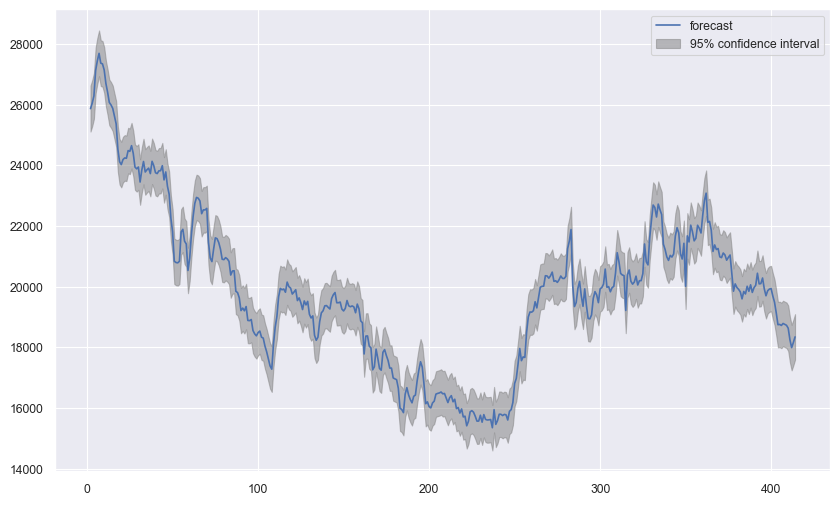

In [464]:
plt.rcParams.update({'figure.figsize': (10,6)})
plot_predict(modelo_fit, 2);
plt.show();

Para medir el error de predicción cometido en las predicciones, utilizaremos las métricas usuales en análisis de series de tiempo: `MAPE, MAE, RMSE, MSE`

In [449]:
def forecast_accuracy(forecast, actual, str_name):
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual)) # MAPE
    mae = np.mean(np.abs(forecast - actual))                 # MAE
    rmse = np.mean((forecast - actual)**2)**.5               # RMSE
    mse = np.mean((forecast - actual)**2)                    # MSE
    r2 = r2_score(forecast, actual)
    
    df_acc = pd.DataFrame({'MAE': [mae],
                           'MSE': [mse],
                           'MAPE': [mape],
                           'RMSE': [rmse],
                           'R2': [r2]},
                          index=[str_name])
    
    return df_acc

## **Rolling forecast**

In [465]:
def arima_rolling(history, test):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions

In [466]:
test_4wl = test.tolist()
yhat_4w  = arima_rolling(train.tolist(), test_4wl)

predicted=18336.501023, expected=18180.000000
predicted=18140.785452, expected=17800.000000
predicted=17795.836544, expected=17700.000000
predicted=17737.605384, expected=17700.000000
predicted=17692.860425, expected=17740.000000
predicted=17704.911249, expected=17520.000000
predicted=17548.283932, expected=17900.000000
predicted=17900.340217, expected=18380.000000
predicted=18334.989467, expected=18320.000000
predicted=18342.915544, expected=18500.000000
predicted=18488.182936, expected=18500.000000
predicted=18476.525185, expected=18500.000000
predicted=18482.524109, expected=18200.000000
predicted=18242.026697, expected=18140.000000
predicted=18143.284907, expected=18300.000000
predicted=18250.745725, expected=17940.000000
predicted=17972.316003, expected=17680.000000
predicted=17724.331571, expected=17700.000000
predicted=17654.144201, expected=17700.000000
predicted=17670.146842, expected=17400.000000
predicted=17464.580759, expected=17740.000000
predicted=17726.965397, expected=1

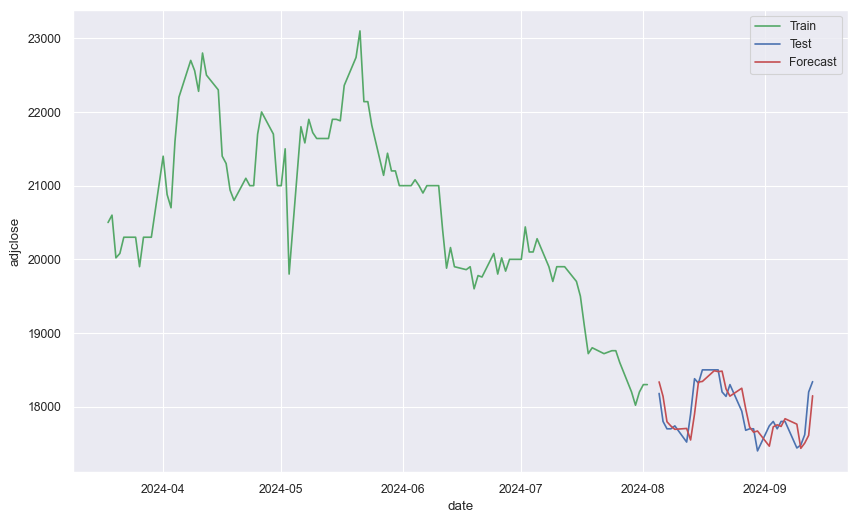

In [467]:
ax = sns.lineplot(x=dates_train[-100:], y=train[-100:], label="Train", color='g')
sns.lineplot(x=dates_test, y=test_4wl, label="Test", color='b')
sns.lineplot(x=dates_test, y=yhat_4w, label="Forecast", color='r')
plt.show()

In [ ]:
def arima_rolling(history: list, test: list, best_order: tuple) -> list:
    predictions: list = []

    for t in range(len(test)):
        model: ARIMA = ARIMA(history, order=best_order)
        model_fit: ARIMAResults = model.fit()
        output: tuple = model_fit.forecast()
        yhat: float = output[0]
        predictions.append(yhat)
        obs: float = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))

    return predictions

train_list: list = train.tolist()

print('ARIMA Rolling - Horizonte de 7 días.')
test7: pd.DataFrame = stock_data.Close[train_size:train_size + 7]
dates_test7: pd.DataFrame = stock_data.Date[train_size:train_size + 7]

test7: list = test7.tolist()
yhat7: list  = arima_rolling(train_list, test7, order)

print('\nARIMA Rolling - Horizonte de 14 días.')
test14: pd.DataFrame = stock_data.Close[train_size:train_size + 14]
dates_test14: pd.DataFrame = stock_data.Date[train_size:train_size + 14]

test14: list = test14.tolist()
yhat14: list  = arima_rolling(train_list, test14, order)

print('\nARIMA Rolling - Horizonte de 21 días.')
test21: pd.DataFrame = stock_data.Close[train_size:train_size + 21]
dates_test21: pd.DataFrame = stock_data.Date[train_size:train_size + 21]

test21: list = test21.tolist()
yhat21: list  = arima_rolling(train_list, test21, order)

print('\nARIMA Rolling - Horizonte de 28 días')
test28: list = test28.tolist()
yhat28: list = arima_rolling(train_list, test28, order)